# Trajectory optimization

In this work, we will try to implement and optimize the trajectory of an expendable two-stage-to-orbit launch vehicle using simplified model.

In [3]:
import numpy as np
import copy
import scipy
import constants as Cst
from modele_atmos import compute_atmos
import lib_trajectory
import matplotlib.pyplot as plt

# Definition of design and optimization variables

The goal is to put a payload into a LEO (250 km $\times$ 250 km) orbit. The payload mass has to be maximized.

## The control and design variables are the following
- mass of the payload (1 variable),
- delta pitch angle for the pitch over maneuver (1 variable),
- bilinear tangent law parameters for the second stage (3 variables).

## The constraints are the following
- $h(t=t_f) = h_{\text{target}}$ (tolerance of 1km)
- $v(t=t_f) = v_{\text{target}}$ (tolerance of 100 m/s)
- $\gamma(t=t_f) = \gamma_{\text{target}}$ (tolerance of 1 deg)

## Several trajectory parameters are considered as fixed for the trajectory optimization
- duration of vertical phase
- duration of pitch over maneuver phase
- duration of exponential decay (second phase of pitch over maneuver)

The trajectory is defined as follows:
* Vertical phase with the pitch angle $\theta = 90\; \text{deg}$

* A pitch-over maneuver with two phases:
   - The evolution of the pitch angle ($\theta$) to have a linear evolution of angle of attack ($\alpha = \theta - \gamma$), with respect to the following law: $\theta = \gamma - \Delta_{\theta_{po}}\frac{t}{\Delta_{t_{po}}}$  with $\gamma$ the flight path angle

   - Exponential decay of angle of attack ($\alpha$) leading to the evolution of the pitch angle: $\theta = \gamma -  \Delta_{\theta_{po}}  \text{exp}\left(-\frac{t}{\Delta_{t_{decay}}}\right)$

* A gravity turn phase in which the pitch angle is defined by $\theta = \gamma$ (i.e. $\alpha = 0$).

* A bilinear tangent law of pitch angle for exoatmospheric flight (flight of second stage) : $\theta = \text{arctan}\left(\frac{a^\xi \text{tan}(\theta_i)+(\text{tan}(\theta_f)-a^\xi \text{tan}(\theta_i)) t'}{a^\xi+(1-a^\xi)t'}\right)$ with $t'$ the normalized time within the phase, $\theta_i$ and $\theta_f$ the initial and final values of pitch angle for this phase, $a$ is fixed to 100 and $\xi$ has to be optimized.   
    
    
<img src="flight_phases.png" alt="Drawing" style="width: 500px;"/>


First, we have to define the launch vehicle model. For this exercise, we will use a Falcon 9 launcher. We consider that the fairing is jetissoned during the stage separation.

In [4]:
Falcon_model={}
#First stage
Falcon_model['First_stage'] = {}
# Propellant mass (kg)
Falcon_model['First_stage']['Propellant_mass'] = 395700.
# Dry mass (kg)
Falcon_model['First_stage']['Dry_mass'] = 25600.
# Specific impulse in vacuum (s)
Falcon_model['First_stage']['Isp_vac'] = 312.
# Mass flow rate (kg/s)
Falcon_model['First_stage']['Mass_flow_rate'] = 9*298.8
# Reference area (m^2)
Falcon_model['First_stage']['Reference_area'] = np.pi*3.7 **2
# Nozzle exit area (m^2)
Falcon_model['First_stage']['Nozzle_exit_area'] = 9*(0.92/2)**2*np.pi

#Second stage
Falcon_model['Second_stage'] = {}
# Propellant mass (kg)
Falcon_model['Second_stage']['Propellant_mass'] = 92670.
# Dry mass (kg)
Falcon_model['Second_stage']['Dry_mass'] = 3900.
# Specific impulse in vacuum (s)
Falcon_model['Second_stage']['Isp_vac'] = 348.
# Mass flow rate (kg/s)
Falcon_model['Second_stage']['Mass_flow_rate'] = 287.45
# Reference area (m^2)
Falcon_model['Second_stage']['Reference_area'] =  np.pi*3.7 **2
# Nozzle exit area (m^2)
Falcon_model['Second_stage']['Nozzle_exit_area'] = (3.3/2)**2*np.pi
# Fairing mass (kg)
Falcon_model['Second_stage']['Fairing_mass'] = 1900.

In [5]:
#Parameters for control
Parameters = {}
Parameters['Control']={}
Parameters['Control']['First_stage'] = {}
Parameters['Control']['First_stage']['Vertical_phase_duration']=10.         #(s)
Parameters['Control']['First_stage']['Pitch_over_duration']=10.             #(s)
Parameters['Control']['First_stage']['Pitch_over_exp_decay_duration']=20.   #(s)

In [6]:
#Specifications of mission
Parameters['Specifications'] = {}
Parameters['Specifications']['Altitude']= 250*1e3         #(m)
Parameters['Specifications']['Flight_path_angle']= 0.     #(deg)
Parameters['Specifications']['Velocity']= 7800.           #(m/s)

Then, we have to define our optimization problem. 

We will use a gradient-based optimizer called SLSQP of the `scipy` package.
[https://docs.scipy.org/doc/scipy/reference/optimize.minimize-slsqp.html](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-slsqp.html)

To create the optimization problem, we need to define :
- the objective function (here the payload mass to be maximized)
- the constraint function (here the reach of the orbit)
- the bounds on the design variables

Design variables order is :
- payload mass (tons)
- initial pitch for second stage (deg)
- final pitch for second stage (deg)
- ksi parameter for bi linear tangent law (-)
- delta pitch parameter for first stage (deg)

We initialize the design variables to:

- $m_{CU} = 20\;\text{t}$
- $\theta_i = 30\;\text{deg}$
- $\theta_f = -3\;\text{deg}$
- $\xi = 0.5$
- $\Delta_\theta = 1\;\text{deg}$


In [7]:
#Definition of objective function for trajectory

def obj_function_trajectory(design_var):
    """
    Function defining the objective function for the optimization
    
    :design_var: design variables of the first stage (payload mass and control law) 
    
    """
    Payload_mass = design_var[0]*1e3
    return - Payload_mass

#Definition of constraint function for trajectory

def constraint_function_trajectory(design_var, Parameters,Rocket_model):
    """
    Function defining the constraints function for the optimization
    
    :design_var: design variables of the first stage (payload mass and control law) 
    
    :Parameters: dictionary of parameters for the simulation
    
    :Rocket_model: dictionary composed of rocket parameters
    
    """
    
    # Integration of first stage trajectory
    flight_history_first_stage = lib_trajectory.trajectory_integration_first_stage(design_var, Parameters,Rocket_model)

    # Integration of second stage trajectory
    flight_history_second_stage = lib_trajectory.trajectory_integration_second_stage(design_var,Parameters,Rocket_model,flight_history_first_stage)
    
    
    # Calculation of discrepancy at the orbit

    discrepancy_altitude = np.abs(Parameters['Specifications']['Altitude']-flight_history_second_stage['altitude'][-1])
    discrepancy_velocity = np.abs(Parameters['Specifications']['Velocity']-flight_history_second_stage['velocity'][-1])
    discrepancy_flight_path_angle = np.abs(Parameters['Specifications']['Flight_path_angle']-flight_history_second_stage['flight_path_angle'][-1])
    
    #Definition of tolerances on state vector at the orbit injection
    tolerance_altitude = 1e3  #(m)
    tolerance_velocity = 100. #(m/s)
    tolerance_flight_path_angle = 1.  #(deg)
    
    return np.array([(tolerance_altitude-discrepancy_altitude)/1e3, tolerance_velocity-discrepancy_velocity,
                     tolerance_flight_path_angle-discrepancy_flight_path_angle])


constraint = lambda x:  constraint_function_trajectory(x,Parameters,Falcon_model)

objective = lambda x:  obj_function_trajectory(x)

design_var = np.array([20.,30.,-3.,0.5,1.])

bounds_design_var = ((5.,30.),(20.,50.),(-5.,10.),(-1,1.),(1.,3.))    

Before launching the optimization process, it is interesting to simulate the trajectory for the initial valules of the control variables 

In [8]:
#Simulation of trajectory
flight_history_first_stage = lib_trajectory.trajectory_integration_first_stage(design_var, Parameters,Falcon_model)

flight_history_second_stage = lib_trajectory.trajectory_integration_second_stage(design_var,Parameters,Falcon_model,flight_history_first_stage)


Several variables are available after the simulation of the trajectory.


In [9]:
print('available variables',flight_history_first_stage.keys())

available variables dict_keys(['time', 'r', 'velocity', 'flight_path_angle', 'longitude', 'mass', 'axial_load_factor', 'qdyn', 'flux', 'altitude', 'AoA', 'pitch_angle', 'rho', 'Pa', 'Drag_coeff', 'thrust', 'thrust_vac', 'mass_flow_rate', 'g'])


- 'time': time of flight
- 'r': radius from the Earth center in m
- 'velocity': velocity of the launcher (m/s)
- 'flight_path_angle': fligth path angle $\gamma$ in deg
- 'longitude': longitude in deg
- 'mass': mass in kg
- 'axial_load_factor': axial load factor (-)
- 'qdyn': dynamic pressure in Pa
- 'flux': heat flux in W/m2
- 'altitude': altitude from Earth surface in m
- 'AoA': Angle of Attack in deg
- 'pitch_angle': Pitch angle in deg
- 'rho': atmosphere density (kg/m3)
- 'Pa': atmospheric pressure at a certain altitude in Pa
- 'Drag_coeff': Drag coefficient CD (-)
- 'Thrust': thrust at a certain altitude in N
- 'Thrust_vac': thrust in the vaccum in N
- 'mass_flow_rate': mass flow rate of the rocket engine in kg/s
- 'g': Gravitational Earth acceleration at a certain altitude (m/s2)


We can plot the evolution of several variables as functions of time

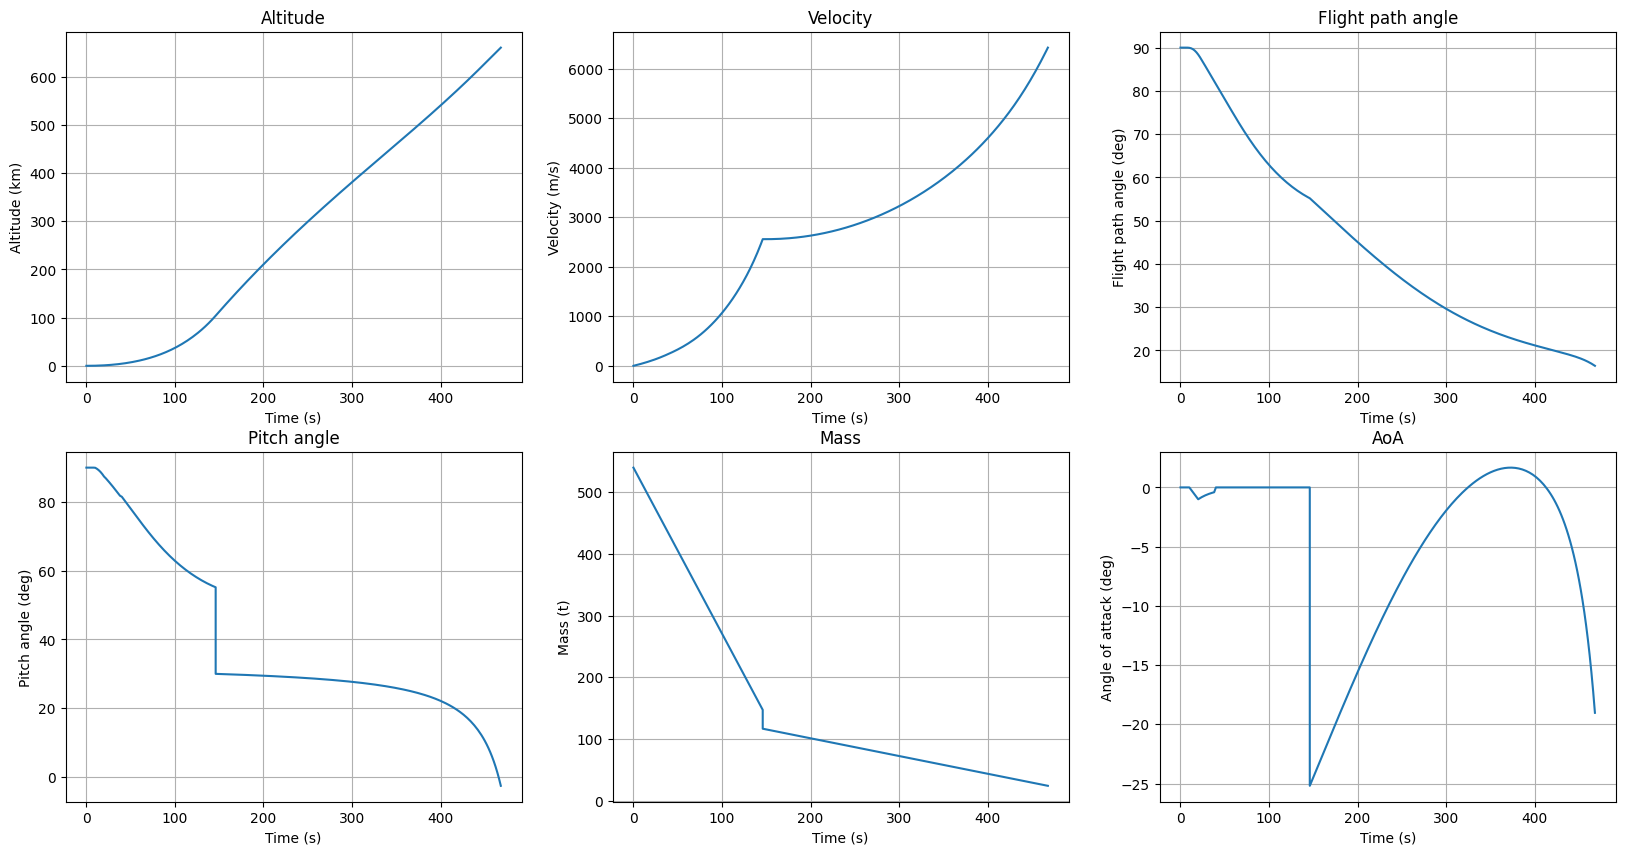

In [10]:
# Plot of trajectory at initial values

#Some nice plots
plt.figure(figsize=(20,10))
plt.subplot(2,3,1)
plt.plot(np.concatenate((flight_history_first_stage['time'],flight_history_first_stage['time'][-1]+flight_history_second_stage['time'])),
         np.concatenate((flight_history_first_stage['altitude']/1e3,flight_history_second_stage['altitude']/1e3)))
plt.title('Altitude')
plt.xlabel('Time (s)')
plt.ylabel('Altitude (km)')

plt.grid()
plt.subplot(2,3,2)

plt.plot(np.concatenate((flight_history_first_stage['time'],flight_history_first_stage['time'][-1]+flight_history_second_stage['time'])),
         np.concatenate((flight_history_first_stage['velocity'],flight_history_second_stage['velocity'])))
plt.title('Velocity')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')

plt.grid()


plt.subplot(2,3,3)
plt.plot(np.concatenate((flight_history_first_stage['time'],flight_history_first_stage['time'][-1]+flight_history_second_stage['time'])),
         np.concatenate((flight_history_first_stage['flight_path_angle'],flight_history_second_stage['flight_path_angle'])))
plt.title('Flight path angle')
plt.xlabel('Time (s)')
plt.ylabel('Flight path angle (deg)')
plt.grid()

plt.subplot(2,3,4)
plt.plot(np.concatenate((flight_history_first_stage['time'],flight_history_first_stage['time'][-1]+flight_history_second_stage['time'])),
         np.concatenate((flight_history_first_stage['pitch_angle'],flight_history_second_stage['pitch_angle'])))
plt.title('Pitch angle')
plt.xlabel('Time (s)')
plt.ylabel('Pitch angle (deg)')

plt.grid()

plt.subplot(2,3,5)
plt.plot(np.concatenate((flight_history_first_stage['time'],flight_history_first_stage['time'][-1]+flight_history_second_stage['time'])),
         np.concatenate((flight_history_first_stage['mass']/1e3,flight_history_second_stage['mass']/1e3)))

plt.title('Mass')
plt.xlabel('Time (s)')
plt.ylabel('Mass (t)')

plt.grid()

plt.subplot(2,3,6)
plt.plot(np.concatenate((flight_history_first_stage['time'],flight_history_first_stage['time'][-1]+flight_history_second_stage['time'])),
         np.concatenate((flight_history_first_stage['AoA'],flight_history_second_stage['AoA'])))

plt.title('AoA')
plt.xlabel('Time (s)')
plt.ylabel('Angle of attack (deg)')

plt.grid()

We can see that the simulated trajectory does not satisfy the constraints (positive as satisfied).

In [11]:
constraint(design_var) 

array([ -409.46394327, -1278.81368277,   -15.45063647])

Then, we launch the optimization process.

In [12]:
# We launch the optimization
sol_opt = scipy.optimize.fmin_slsqp(objective,
                              design_var,
                              f_ieqcons = constraint,
                              bounds = bounds_design_var,
                              disp=True)

print(sol_opt)

Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -20163.1679545398
            Iterations: 41
            Function evaluations: 281
            Gradient evaluations: 37
[20.16316795 31.71955585 -1.97663919 -0.04044359  2.17526685]


We can verify that the constraints are effectively satisfied:

In [13]:
constraint(sol_opt)

array([-2.90242955e-06, -1.01346905e-05,  3.62224007e-08])

In [14]:
# We simulate the optimal solution
flight_history_first_stage = lib_trajectory.trajectory_integration_first_stage(sol_opt, Parameters,Falcon_model)
flight_history_second_stage = lib_trajectory.trajectory_integration_second_stage(sol_opt,Parameters,Falcon_model,flight_history_first_stage)

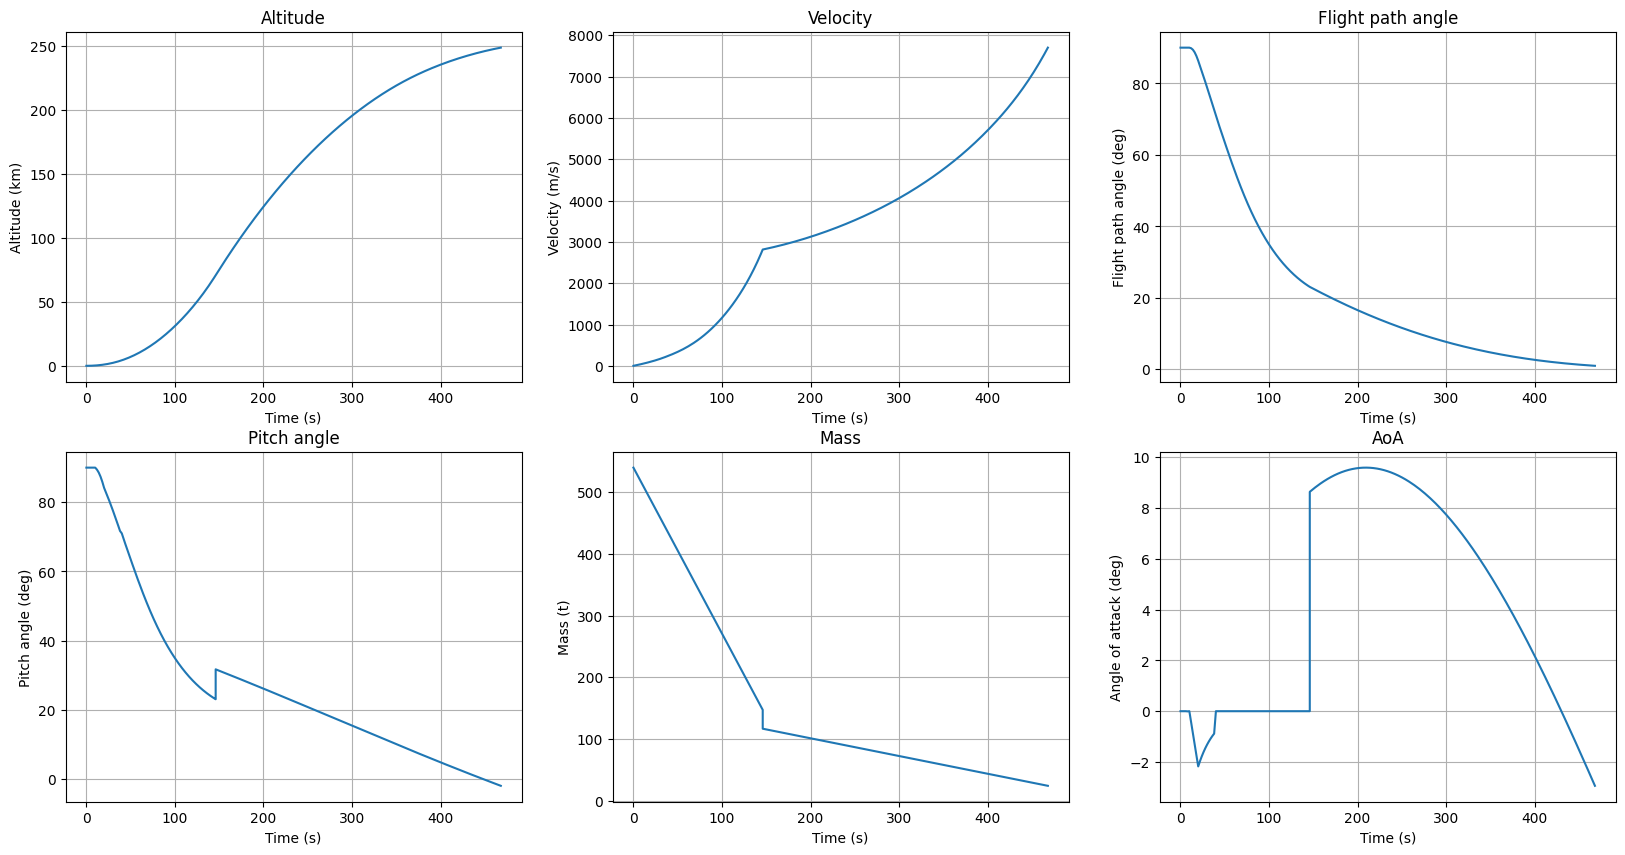

In [15]:
# Plot of trajectory at initial values

#Simulation of trajectory
flight_history_first_stage = lib_trajectory.trajectory_integration_first_stage(sol_opt, Parameters,Falcon_model)
flight_history_second_stage = lib_trajectory.trajectory_integration_second_stage(sol_opt,Parameters,Falcon_model,flight_history_first_stage)

#Some nice plots
plt.figure(figsize=(20,10))
plt.subplot(2,3,1)
plt.plot(np.concatenate((flight_history_first_stage['time'],flight_history_first_stage['time'][-1]+flight_history_second_stage['time'])),
         np.concatenate((flight_history_first_stage['altitude']/1e3,flight_history_second_stage['altitude']/1e3)))
plt.title('Altitude')
plt.xlabel('Time (s)')
plt.ylabel('Altitude (km)')

plt.grid()
plt.subplot(2,3,2)

plt.plot(np.concatenate((flight_history_first_stage['time'],flight_history_first_stage['time'][-1]+flight_history_second_stage['time'])),
         np.concatenate((flight_history_first_stage['velocity'],flight_history_second_stage['velocity'])))
plt.title('Velocity')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')

plt.grid()


plt.subplot(2,3,3)
plt.plot(np.concatenate((flight_history_first_stage['time'],flight_history_first_stage['time'][-1]+flight_history_second_stage['time'])),
         np.concatenate((flight_history_first_stage['flight_path_angle'],flight_history_second_stage['flight_path_angle'])))
plt.title('Flight path angle')
plt.xlabel('Time (s)')
plt.ylabel('Flight path angle (deg)')
plt.grid()

plt.subplot(2,3,4)
plt.plot(np.concatenate((flight_history_first_stage['time'],flight_history_first_stage['time'][-1]+flight_history_second_stage['time'])),
         np.concatenate((flight_history_first_stage['pitch_angle'],flight_history_second_stage['pitch_angle'])))
plt.title('Pitch angle')
plt.xlabel('Time (s)')
plt.ylabel('Pitch angle (deg)')

plt.grid()

plt.subplot(2,3,5)
plt.plot(np.concatenate((flight_history_first_stage['time'],flight_history_first_stage['time'][-1]+flight_history_second_stage['time'])),
         np.concatenate((flight_history_first_stage['mass']/1e3,flight_history_second_stage['mass']/1e3)))

plt.title('Mass')
plt.xlabel('Time (s)')
plt.ylabel('Mass (t)')

plt.grid()

plt.subplot(2,3,6)
plt.plot(np.concatenate((flight_history_first_stage['time'],flight_history_first_stage['time'][-1]+flight_history_second_stage['time'])),
         np.concatenate((flight_history_first_stage['AoA'],flight_history_second_stage['AoA'])))

plt.title('AoA')
plt.xlabel('Time (s)')
plt.ylabel('Angle of attack (deg)')

plt.grid()

## Question : Compute the different losses 

Losses are given :
\begin{align*} 
\displaystyle \int_{t_0}^{t_f} \dot{V} dt &=& \displaystyle \int_{t_0}^{t_f} \frac{T_{vacuum}}{m} dt &-&\displaystyle \int_{t_0}^{t_f} \cos (\theta-\gamma+\delta)) \frac{Pa(r)A_n}{m} dt&-
&  \displaystyle \int_{t_0}^{t_f} (1- \cos (\theta-\gamma+\delta)) \frac{T_{vacuum}}{m} dt\\
&-&\displaystyle \int_{t_0}^{t_f} \frac{D}{m} dt &-& \displaystyle \int_{t_0}^{t_f} g(r) sin\gamma dt
\end{align*}

In [16]:
import scipy

Dv_first_stage = {}
Dv_first_stage['Dv_p'] = scipy.integrate.simpson(flight_history_first_stage['thrust_vac']/flight_history_first_stage['mass'],
                                                 flight_history_first_stage['time'])

Dv_first_stage['loss_nozzle'] = scipy.integrate.simpson((np.cos(np.deg2rad(flight_history_first_stage['AoA'])))*flight_history_first_stage['Pa']*Falcon_model['First_stage']['Nozzle_exit_area']/flight_history_first_stage['mass'],
                                                      flight_history_first_stage['time'])

Dv_first_stage['loss_AoA'] = scipy.integrate.simpson((1-np.cos(np.deg2rad(flight_history_first_stage['AoA'])))*flight_history_first_stage['thrust_vac']/flight_history_first_stage['mass'],
                                                     flight_history_first_stage['time'])

Dv_first_stage['loss_aero'] = scipy.integrate.simpson((flight_history_first_stage['qdyn']*flight_history_first_stage['Drag_coeff']*Falcon_model['First_stage']['Reference_area'])/flight_history_first_stage['mass'],
                                                       flight_history_first_stage['time'])

Dv_first_stage['loss_gravity'] = scipy.integrate.simpson((flight_history_first_stage['g']*np.sin(np.deg2rad(flight_history_first_stage['flight_path_angle']))),
                                                       flight_history_first_stage['time'])


Dv_second_stage = {}
Dv_second_stage['Dv_p'] = scipy.integrate.simpson(flight_history_second_stage['thrust_vac']/flight_history_second_stage['mass'],
                                                  flight_history_second_stage['time'])

Dv_second_stage['loss_nozzle'] = scipy.integrate.simpson((np.cos(np.deg2rad(flight_history_second_stage['AoA'])))*flight_history_second_stage['Pa']*Falcon_model['Second_stage']['Nozzle_exit_area']/flight_history_second_stage['mass'],
                                                      flight_history_second_stage['time'])


Dv_second_stage['loss_AoA'] = scipy.integrate.simpson((1-np.cos(np.deg2rad(flight_history_second_stage['AoA'])))*flight_history_second_stage['thrust_vac']/flight_history_second_stage['mass'],
                                                      flight_history_second_stage['time'])

Dv_second_stage['loss_aero'] = scipy.integrate.simpson((flight_history_second_stage['qdyn']*flight_history_second_stage['Drag_coeff']*Falcon_model['Second_stage']['Reference_area'])/flight_history_second_stage['mass'],
                                                       flight_history_second_stage['time'])

Dv_second_stage['loss_gravity'] = scipy.integrate.simpson((flight_history_second_stage['g']*np.sin(np.deg2rad(flight_history_second_stage['flight_path_angle']))),
                                                       flight_history_second_stage['time'])


print(Dv_first_stage['Dv_p'],Dv_first_stage['loss_AoA'],Dv_first_stage['loss_nozzle'] ,Dv_first_stage['loss_aero'],Dv_first_stage['loss_gravity'] )

print(Dv_second_stage['Dv_p'],Dv_second_stage['loss_AoA'],Dv_second_stage['loss_nozzle'],Dv_second_stage['loss_aero'],Dv_second_stage['loss_gravity'] )


sum_losses = Dv_first_stage['loss_AoA']+Dv_first_stage['loss_nozzle']+Dv_first_stage['loss_aero']+Dv_first_stage['loss_gravity']+Dv_second_stage['loss_AoA']+Dv_second_stage['loss_nozzle']+Dv_second_stage['loss_aero']+Dv_second_stage['loss_gravity'] 

print(sum_losses)

3974.2432899059063 0.14914187924590294 60.612369645146345 57.05762876806572 1043.08845419621
5373.670211308246 28.283868497853323 0.0019115809054763384 0.0 460.22023861454437
1649.4136131819712


In [20]:
Dv_second_stage['Dv_p']+Dv_first_stage['Dv_p']

9347.913501214152

In [17]:
Dv_orbit = np.sqrt(5.9736e24*6.67408e-11/(250e3+ 6378137.0))
print(Dv_orbit)

7755.647020095385


In [21]:
#Theoretical DV
Payload_mass = 20163.1

GLOW = Falcon_model['First_stage']['Propellant_mass']  + Falcon_model['First_stage']['Dry_mass']  +\
       Falcon_model['Second_stage']['Propellant_mass']    + Falcon_model['Second_stage']['Dry_mass'] + Falcon_model['Second_stage']['Fairing_mass']+Payload_mass
    
    
    
DV_first_stage =  Falcon_model['First_stage']['Isp_vac'] *9.80665 * np.log((GLOW)/(GLOW -Falcon_model['First_stage']['Propellant_mass']))

DV_second_stage =  Falcon_model['Second_stage']['Isp_vac'] *9.80665 * np.log(( Falcon_model['Second_stage']['Propellant_mass']+ Falcon_model['Second_stage']['Dry_mass']+Payload_mass)/
                                                                             ( Falcon_model['Second_stage']['Dry_mass'] +Payload_mass))

DV_total = DV_second_stage + DV_first_stage
print(DV_total)

9428.209497961825


In [19]:
#Real DV : 
print(DV_total - sum_losses)

7778.795884779854


## Question : Plot the dynamic pressure profile

Text(0, 0.5, 'Dynamic pressure (Pa)')

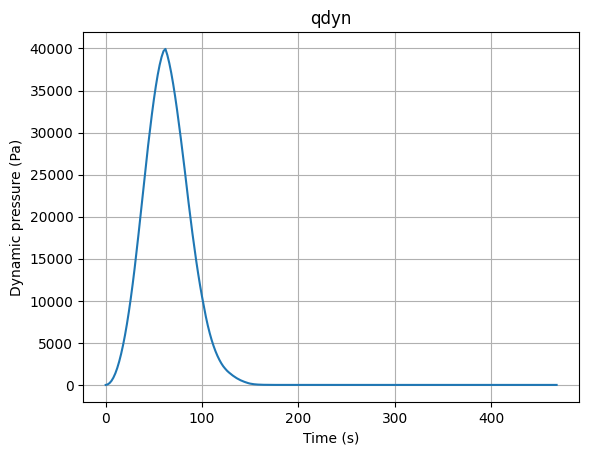

In [22]:
plt.plot(np.concatenate((flight_history_first_stage['time'],flight_history_first_stage['time'][-1]+flight_history_second_stage['time'])),
         np.concatenate((flight_history_first_stage['qdyn'],flight_history_second_stage['qdyn'])))
plt.grid()

plt.title('qdyn')
plt.xlabel('Time (s)')
plt.ylabel('Dynamic pressure (Pa)')

### On the dynamic pressure profile for this trajectory, we can see that he Pdyn is greater than 40kPa. 

Try to reformulate the optimization problem to respect a constraint about $\text{max}(Pdyn)\leq38\text{kPa}$ and change fixed trajectory parameters to satisfy this constraint.

In [23]:
#Definition of constraint function for trajectory
def constraint_function_trajectory_pdyn(design_var, Parameters,Rocket_model):
    flight_history_first_stage = lib_trajectory.trajectory_integration_first_stage(design_var, Parameters,Rocket_model)


    flight_history_second_stage = lib_trajectory.trajectory_integration_second_stage(design_var,Parameters,Rocket_model,flight_history_first_stage)
    
    discrepancy_altitude = np.abs(Parameters['Specifications']['Altitude']-flight_history_second_stage['altitude'][-1])
    discrepancy_velocity = np.abs(Parameters['Specifications']['Velocity']-flight_history_second_stage['velocity'][-1])
    discrepancy_flight_path_angle = np.abs(Parameters['Specifications']['Flight_path_angle']-flight_history_second_stage['flight_path_angle'][-1])
    
    constraint_pdyn =  np.array([-Parameters['Specifications']['Dynamic_pressure'] + np.max(flight_history_first_stage['qdyn'])])

    tolerance_altitude = 1e3
    tolerance_velocity = 100.
    tolerance_flight_path_angle = 1.
    
    return np.array([(tolerance_altitude-discrepancy_altitude)/1e3,
                     tolerance_velocity-discrepancy_velocity,
                     tolerance_flight_path_angle-discrepancy_flight_path_angle,
                     -constraint_pdyn])

#Parameters for control
Parameters['Control']={}
Parameters['Control']['First_stage'] = {}
Parameters['Control']['First_stage']['Vertical_phase_duration']=10.
Parameters['Control']['First_stage']['Pitch_over_duration']=10.
Parameters['Control']['First_stage']['Pitch_over_exp_decay_duration']=20.

Parameters['Specifications']['Dynamic_pressure']= 38000.

design_var = np.array([20.,30.,-3.,0.5,1.])

bounds_design_var = ((5.,25.),(20.,50.),(-5.,10.),(-1,1.),(1.,3.))  

constraint = lambda x:  constraint_function_trajectory_pdyn(x,Parameters,Falcon_model)

objective = lambda x:  obj_function_trajectory(x)

# We launch the optimization
sol_opt_pdyn = scipy.optimize.fmin_slsqp(objective,
                              sol_opt,
                              f_ieqcons = constraint,
                              bounds = bounds_design_var,
                              disp=True)
print(sol_opt_pdyn)

D:\mbalesde\AppData\Local\Temp\ipykernel_12636\3013955865.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([(tolerance_altitude-discrepancy_altitude)/1e3,


Optimization terminated successfully    (Exit mode 0)
            Current function value: -19591.5199472804
            Iterations: 50
            Function evaluations: 336
            Gradient evaluations: 46
[19.59151995 20.         -0.5159725  -0.17073681  1.90744618]


In [24]:
constraint_function_trajectory_pdyn(sol_opt_pdyn,Parameters,Falcon_model)

D:\mbalesde\AppData\Local\Temp\ipykernel_12636\3013955865.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([(tolerance_altitude-discrepancy_altitude)/1e3,


array([-1.8028123304247857e-06, 4.018853360321373e-06,
       0.24105295042124542, array([-6.83161488e-07])], dtype=object)

In [25]:
# We simulate the optimal solution
flight_history_first_stage = lib_trajectory.trajectory_integration_first_stage(sol_opt_pdyn, Parameters,Falcon_model)
flight_history_second_stage = lib_trajectory.trajectory_integration_second_stage(sol_opt_pdyn,Parameters,Falcon_model,flight_history_first_stage)
np.max(flight_history_first_stage['qdyn'])

38000.00000068316

Text(0, 0.5, 'Dynamic pressure (Pa)')

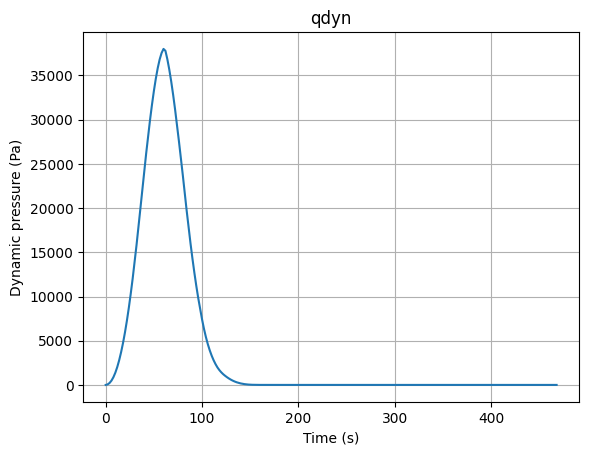

In [26]:
# We simulate the optimal solution
flight_history_first_stage = lib_trajectory.trajectory_integration_first_stage(sol_opt_pdyn, Parameters,Falcon_model)
flight_history_second_stage = lib_trajectory.trajectory_integration_second_stage(sol_opt_pdyn,Parameters,Falcon_model,flight_history_first_stage)

plt.plot(np.concatenate((flight_history_first_stage['time'],flight_history_first_stage['time'][-1]+flight_history_second_stage['time'])),
         np.concatenate((flight_history_first_stage['qdyn'],flight_history_second_stage['qdyn'])))

plt.title('qdyn')
plt.grid()
plt.xlabel('Time (s)')
plt.ylabel('Dynamic pressure (Pa)')